In this notebook we calculated user sessions from logged data. 
We compared our calculated sessions to visit_ids that are defined in the client code.
https://jira.dev.bbc.co.uk/browse/DATALAB-1950

SQL query partitioned by dt
```sql
WITH 
aux AS
(
  SELECT
  hashed_id,
  from_big_endian_64(xxhash64(to_utf8(hashed_id))) AS user_id,
  source,
  page_name,
  visit_id,
  time_spent_per_visit,
  dt,
  event_start_datetime,
  LAG(event_start_datetime) OVER(PARTITION BY hashed_id ORDER BY event_start_datetime) AS previous_time
FROM "audience"."audience_activity"
WHERE dt BETWEEN '20190901'AND '20190930'
AND hashed_id is NOT null AND NOT hashed_id='undefined'
AND destination='PS_VOICE'
AND from_big_endian_64(xxhash64(to_utf8(hashed_id))) % 500= 42
),

aux2 AS
(
    SELECT *
    , date_diff('minute',date_parse(previous_time,'%Y-%m-%dT%H:%i:%s')
    , date_parse(event_start_datetime,'%Y-%m-%dT%H:%i:%s')) as difference
    FROM aux
),

aux3 AS
(
    SELECT *, 
    CASE
        WHEN 0<=difference and difference <=30 THEN 0
        WHEN difference>30 THEN 1
        -- this case catches the first session for each user
        WHEN difference IS NULL THEN 1
    END AS session_boolean
  
FROM aux2
)
  
SELECT 
*, 
SUM(session_boolean) OVER(PARTITION BY dt ORDER BY user_id, event_start_datetime) AS session_id
FROM aux3
```

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 500)

In [2]:
df=pd.read_csv("data/partitionedbydt.csv")

In [3]:
df.nunique()

hashed_id                 376
user_id                   376
source                      2
page_name                 193
visit_id                 9920
time_spent_per_visit       10
dt                         30
event_start_datetime    31189
previous_time           31020
difference               2461
session_boolean             2
session_id                361
dtype: int64

Session_id is a session id that we calculated, visit_id is a a session_id present in a client code
Both of these fields are partioned by dt (i.e. the count of sessions/visits resets at midnight), so they need to be combined with dt to give us a unique field.

In [43]:
#Create a unique session id by combining a daily session id with dt
def create_session_id(row):
    return str(row["dt"]) + str(row.session_id)

df = (
    df
    .assign(session_id_date = df.apply(create_session_id, axis=1))
)

In [44]:
df.nunique()

hashed_id                  376
user_id                    376
source                       2
page_name                  193
visit_id                  9920
time_spent_per_visit        10
dt                          30
event_start_datetime     31189
previous_time            31020
difference                2461
session_boolean              2
non_unique_session_id      361
session_id                9297
visit_id_date             9973
session_id_date           9297
dtype: int64

In [45]:
# From our research we know that the visit_id field is not unique on its own (it's a count of visitors of a particular website each day).
# We will combine it with the dt field to make it unique.
def create_visit_id_date(row):
    return str(row["dt"]) + str(row.visit_id)

df = (
    df
    .assign(visit_id_date = df.apply(create_visit_id_date, axis=1))
)

df.head()

,hashed_id,user_id,source,page_name,visit_id,time_spent_per_visit,dt,event_start_datetime,previous_time,difference,session_boolean,non_unique_session_id,session_id,visit_id_date,session_id_date
0,vHRgE-2BMz5B4AckjtLEy7RU-K71gHYacii4YxblfRQ,42194686999630042,Events,voice.alexa.amazon-direct-routed-radio.page,406561,Between 2 mins and 5 mins,20190925,2019-09-25T06:05:44,2019-09-24T07:34:12,1351.0,1,1,201909251,20190925406561,20190925201909251
1,vHRgE-2BMz5B4AckjtLEy7RU-K71gHYacii4YxblfRQ,42194686999630042,Events,voice.alexa.radio.play-radio.page,406561,Between 2 mins and 5 mins,20190925,2019-09-25T06:05:50,2019-09-25T06:05:44,0.0,0,1,201909251,20190925406561,20190925201909251
2,vHRgE-2BMz5B4AckjtLEy7RU-K71gHYacii4YxblfRQ,42194686999630042,AV,bbc radio four extra,406561,Between 2 mins and 5 mins,20190925,2019-09-25T06:05:50,2019-09-25T06:05:50,0.0,0,1,201909251,20190925406561,20190925201909251
3,vHRgE-2BMz5B4AckjtLEy7RU-K71gHYacii4YxblfRQ,42194686999630042,Events,voice.alexa.radio.pause-radio.page,406561,Between 2 mins and 5 mins,20190925,2019-09-25T06:08:43,2019-09-25T06:05:50,2.0,0,1,201909251,20190925406561,20190925201909251
4,vHRgE-2BMz5B4AckjtLEy7RU-K71gHYacii4YxblfRQ,42194686999630042,AV,bbc radio four extra,406561,Between 2 mins and 5 mins,20190925,2019-09-25T06:08:43,2019-09-25T06:08:43,0.0,0,1,201909251,20190925406561,20190925201909251


In [46]:
df['visit_id_date'].nunique()

9973

In [47]:
#Comparison between session_id and visit_id.
dist=pd.DataFrame(df[['session_id_date','visit_id_date',]].copy(), columns=['session_id_date','visit_id_date'])
dist.nunique()

session_id_date    9297
visit_id_date      9973
dtype: int64

There are more unique visit_ids than session_ids. 
We would expect than on average an individual session_id encompasses more events than a visit_id.
Also, the same session_id might have a few different visit_ids assign to it (the total number of events adds up).

In [48]:
#count unique combinations
df_noduplicates=df[['visit_id_date','session_id_date',]].drop_duplicates()
df_noduplicates

,visit_id_date,session_id_date
0,20190925406561,20190925201909251
10,201909254317721,20190925201909252
15,20190925360691,20190925201909253
18,20190925967021,20190925201909254
19,20190925174381,20190925201909255
...,...,...
48967,201909201043381,2019092020190920317
48968,201909203670771,2019092020190920318
48971,201909203939741,2019092020190920319
48972,201909201445702,2019092020190920320


In [49]:
#Count how many visit_id fields belong to an individual session_id.
df_noduplicates['session_id_date'].value_counts()

2019090120190901109    5
201909092019090980     5
2019090820190908119    4
2019092120190921205    4
201909052019090527     4
                      ..
2019092320190923309    1
201909222019092229     1
2019091220190912165    1
2019090920190909194    1
201909222019092247     1
Name: session_id_date, Length: 9297, dtype: int64

Text(0.5, 0, 'Number of visit_ids with the same session_id')

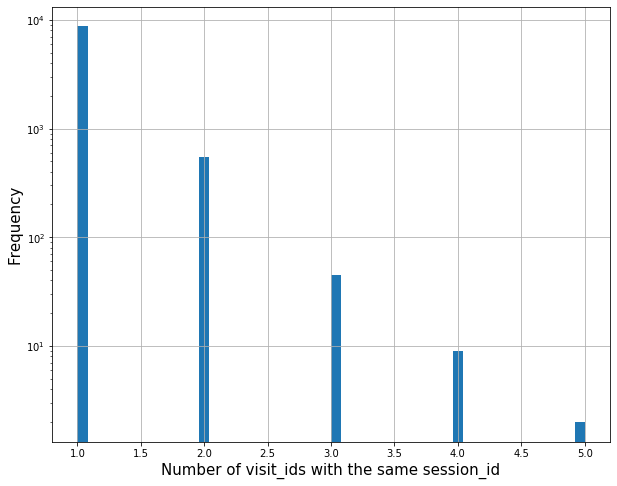

In [50]:
plt.figure(figsize=[10,8])
plt.yscale('log')
df_noduplicates['session_id_date'].value_counts().hist(bins=50)
plt.ylabel('Frequency',fontsize=15)
plt.xlabel('Number of visit_ids with the same session_id',fontsize=15)

Next few examples illustrate how the same session id can be assigned multiple visit ids.

In [51]:
df[df['session_id_date']=='2019090980']

,hashed_id,user_id,source,page_name,visit_id,time_spent_per_visit,dt,event_start_datetime,previous_time,difference,session_boolean,non_unique_session_id,session_id,visit_id_date,session_id_date


In [52]:
df[df['session_id_date']=='20190901109']

,hashed_id,user_id,source,page_name,visit_id,time_spent_per_visit,dt,event_start_datetime,previous_time,difference,session_boolean,non_unique_session_id,session_id,visit_id_date,session_id_date


In [53]:
df[df['session_id_date']=='20190929132']

,hashed_id,user_id,source,page_name,visit_id,time_spent_per_visit,dt,event_start_datetime,previous_time,difference,session_boolean,non_unique_session_id,session_id,visit_id_date,session_id_date


In [54]:
df[df['session_id_date']=='20190902292']

,hashed_id,user_id,source,page_name,visit_id,time_spent_per_visit,dt,event_start_datetime,previous_time,difference,session_boolean,non_unique_session_id,session_id,visit_id_date,session_id_date


In [55]:
df[df['session_id_date']=='2019091620']

,hashed_id,user_id,source,page_name,visit_id,time_spent_per_visit,dt,event_start_datetime,previous_time,difference,session_boolean,non_unique_session_id,session_id,visit_id_date,session_id_date


Differences between a visit_id and a a session_id:

-a new session id is initiated if no activitity was registered for more than 30 minutes

-a new visit is is initiated if no activitity was registered for more than 30 minutes, but sometimes it gets initiated more often. We are not sure why.


In [56]:
df_noduplicates['visit_id_date'].value_counts()

201909132848641    1
20190912284431     1
201909044009652    1
20190906620211     1
20190924390132     1
                  ..
20190924315012     1
201909163229461    1
201909062249861    1
20190919827361     1
201909132540381    1
Name: visit_id_date, Length: 9973, dtype: int64

An visit_id field has only one session_id field that corresponds to it.

In [58]:
#Count number of events registered per session
aux_df=df['session_id_date'].value_counts().reset_index()
aux_df

,index,session_id_date
0,2019091820190918135,235
1,201909152019091553,113
2,2019092720190927109,107
3,201909262019092627,102
4,2019090420190904302,77
...,...,...
9292,201909282019092812,1
9293,2019090720190907315,1
9294,2019092820190928184,1
9295,20190912201909122,1


In [59]:
#Count number of events registered per visit
aux2_df=df['visit_id_date'].value_counts().reset_index()
aux2_df

,index,visit_id_date
0,201909183984862,235
1,201909152869751,113
2,201909271082922,107
3,20190926257642,80
4,20190904152222,77
...,...,...
9968,201909081036971,1
9969,201909173090541,1
9970,201909244306001,1
9971,201909171213121,1


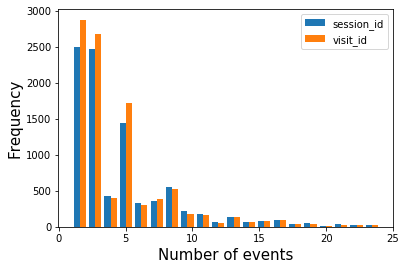

In [60]:
x=aux_df[aux_df['session_id_date']<25]['session_id_date']
y=aux2_df[aux2_df['visit_id_date']<25]['visit_id_date']

plt.hist([x, y], bins=20, label=['session_id','visit_id'])
plt.legend(loc='upper right')
plt.ylabel('Frequency',fontsize=15)
plt.xlabel('Number of events',fontsize=15)
plt.show()


This plot confirms our earlier expactations: 

on average an individual visit_id corresponds to fewer events than an individual session_id.